In [1]:
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints
import pickle

Using TensorFlow backend.


In [0]:

with open('caltech_dataset.pickle', 'rb') as data:
    X_train, X_test, y_train, y_test = pickle.load(data)
X_train = X_train.transpose(0, 3, 2, 1)
X_test = X_test.transpose(0, 3, 2, 1)

In [5]:
#X_train = X_train.transpose(0, 3, 2, 1)
##X_test = X_test.transpose(0, 3, 2, 1)
print(X_train.shape)
print(X_test.shape)

(6941, 3, 150, 100)
(1736, 3, 150, 100)


In [0]:
class MinibatchDiscrimination(Layer):
    """Concatenates to each sample information about how different the input
    features for that sample are from features of other samples in the same
    minibatch, as described in Salimans et. al. (2016). Useful for preventing
    GANs from collapsing to a single output. When using this layer, generated
    samples and reference samples should be in separate batches.
    # Example
    ```python
        # apply a convolution 1d of length 3 to a sequence with 10 timesteps,
        # with 64 output filters
        model = Sequential()
        model.add(Convolution1D(64, 3, border_mode='same', input_shape=(10, 32)))
        # now model.output_shape == (None, 10, 64)
        # flatten the output so it can be fed into a minibatch discrimination layer
        model.add(Flatten())
        # now model.output_shape == (None, 640)
        # add the minibatch discrimination layer
        model.add(MinibatchDiscrimination(5, 3))
        # now model.output_shape = (None, 645)
    ```
    # Arguments
        nb_kernels: Number of discrimination kernels to use
            (dimensionality concatenated to output).
        kernel_dim: The dimensionality of the space where closeness of samples
            is calculated.
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        weights: list of numpy arrays to set as initial weights.
        W_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the main weights matrix.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        W_constraint: instance of the [constraints](../constraints.md) module
            (eg. maxnorm, nonneg), applied to the main weights matrix.
        input_dim: Number of channels/dimensions in the input.
            Either this argument or the keyword argument `input_shape`must be
            provided when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(samples, input_dim + nb_kernels)`.
    # References
        - [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)
    """

    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2

        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = self.add_weight(shape=(self.nb_kernels, input_dim, self.kernel_dim),
            initializer=self.init,
            name='kernel',
            regularizer=self.W_regularizer,
            trainable=True,
            constraint=self.W_constraint)

        # Set built to true.
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = K.reshape(K.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], 1)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = {'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim}
        base_config = super(MinibatchDiscrimination, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
# -*- coding: utf-8 -*-
"""
file: ACGAN - CIFAR10.py
author: Luke
de
Oliveira(lukedeo @ vaitech.io)
contributor: KnightTuYa(398225157 @ qq.com)
Consult
https: // github.com / lukedeo / keras - acgan
for MNIST version!
Consult
https: // github.com / soumith / ganhacks
for GAN trick!
I directly use Minibatch Layer Code from:
https://github.com/forcecore/Keras-GAN-Animeface-Character
Thanks for the great work!
I am still not satisfied with the generated images yet, Any suggestion is welcomed!
"""

with open('caltech_dataset.pickle', 'rb') as data:
    X_train, X_test, y_train, y_test = pickle.load(data)
X_train = X_train.transpose(0, 3, 1, 2)
X_test = X_test.transpose(0, 3, 1, 2)


from __future__ import print_function
import os
from collections import defaultdict

try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image
from six.moves import range
import keras.backend as K
from keras.datasets import cifar10, mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.utils.generic_utils import Progbar

import matplotlib.pyplot as plt
from keras.layers.noise import GaussianNoise
import numpy as np

np.random.seed(1337)
class_num = 101
K.set_image_dim_ordering('th')
path = "images"  # The path to store the generated images
load_weight = False
# Set True if you need to reload weight
load_epoch = 73  # Decide which epoch to reload weight, please check your file name

def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 3, 32, 32)
    cnn = Sequential()
    cnn.add(Dense(384 * 2 * 3, input_dim=latent_size, activation='relu',
                  kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(Reshape((384, 2, 3)))

    cnn.add(Conv2DTranspose(192, kernel_size=5, strides=5, padding='same', activation='relu',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())

    cnn.add(Conv2DTranspose(96, kernel_size=5, strides=5, padding='same', activation='relu',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())

    cnn.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.summary()
    # this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size,))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    # 10 classes in CIFAR-10
    cls = Flatten()(Embedding(101, latent_size,
                              embeddings_initializer='glorot_normal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(GaussianNoise(0.05, input_shape=(3, 100, 150)))  # Add this layer to prevent D from overfitting!

    cnn.add(Conv2D(16, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(32, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(128, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(256, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(512, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    cnn.add(MinibatchDiscrimination(50, 30))

    image = Input(shape=(3, 100, 150))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation',
                 kernel_initializer='glorot_normal', bias_initializer='Zeros')(features)
    aux = Dense(class_num, activation='softmax', name='auxiliary',
                kernel_initializer='glorot_normal', bias_initializer='Zeros')(features)

    return Model(image, [fake, aux])


if __name__ == '__main__':

    # batch and latent size taken from the paper
    nb_epochs = 100
    batch_size = 100
    latent_size = 210

    # Adam parameters suggested in https://arxiv.org/abs/1511.06434
    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator, Choose Adam as optimizer according to GANHACK
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    generator = build_generator(latent_size)

    latent = Input(shape=(latent_size,))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])
    print(fake.shape)
    # we only want to be able to train generator for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    combined.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    nb_train, nb_test = X_train.shape[0], X_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    if load_weight:
        generator.load_weights('params_generator_epoch_{0:03d}.hdf5'.format(load_epoch))
        discriminator.load_weights('params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch))
    else:
        load_epoch = 0

    for epoch in range(nb_epochs):
        print('Epoch {} of {}'.format(load_epoch + 1, nb_epochs))
        load_epoch += 1
        nb_batches = int(X_train.shape[0] / batch_size)
        progress_bar = Progbar(target=nb_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(nb_batches):
            progress_bar.update(index)
            # generate a new batch of noise
            noise = np.random.normal(0, 0.5, (batch_size, latent_size))

            # get a batch of real images
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, class_num, batch_size)

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (batch_size, 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            disc_real_weight = [np.ones(batch_size), 2 * np.ones(batch_size)]
            disc_fake_weight = [np.ones(batch_size), np.zeros(batch_size)]

            # According to GANHACK, We training our ACGAN-CIFAR10 in Real->D, Fake->D,
            # Noise->G, rather than traditional method: [Real, Fake]->D, Noise->G, actully,
            # it really make sense!

            for train_ix in range(3):
                if index % 30 != 0:
                    X_real = image_batch
                    # Label Soomthing
                    y_real = np.random.uniform(0.7, 1.2, size=(batch_size,))
                    aux_y1 = label_batch.reshape(-1, )
                    epoch_disc_loss.append(discriminator.train_on_batch(X_real, [y_real, aux_y1]))
                    # Label Soomthing
                    X_fake = generated_images
                    y_fake = np.random.uniform(0.0, 0.3, size=(batch_size,))
                    aux_y2 = sampled_labels

                    # see if the discriminator can figure itself out...
                    epoch_disc_loss.append(discriminator.train_on_batch(X_fake, [y_fake, aux_y2]))
                else:
                    # make the labels the noisy for the discriminator: occasionally flip the labels
                    # when training the discriminator
                    X_real = image_batch
                    y_real = np.random.uniform(0.0, 0.3, size=(batch_size,))
                    aux_y1 = label_batch.reshape(-1, )

                    epoch_disc_loss.append(discriminator.train_on_batch(X_real, [y_real, aux_y1]))
                    # Label Soomthing
                    X_fake = generated_images
                    y_fake = np.random.uniform(0.7, 1.2, size=(batch_size,))
                    aux_y2 = sampled_labels

                    # see if the discriminator can figure itself out...
                    epoch_disc_loss.append(discriminator.train_on_batch(X_fake, [y_fake, aux_y2]))
            # make new noise. we generate Guassian Noise rather than Uniform Noise according to GANHACK
            noise = np.random.normal(0, 0.5, (2 * batch_size, latent_size))
            sampled_labels = np.random.randint(0, class_num, 2 * batch_size)

            # we want to train the generator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.random.uniform(0.7, 1.2, size=(2 * batch_size,))

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

        print('\nTesting for epoch {}:'.format(load_epoch))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.normal(0, 0.5, (nb_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, class_num, nb_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        X = np.concatenate((X_test, generated_images))
        y = np.array([1] * nb_test + [0] * nb_test)
        aux_y = np.concatenate((y_test.reshape(-1, ), sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            X, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.normal(0, 0.5, (2 * nb_test, latent_size))
        sampled_labels = np.random.randint(0, class_num, 2 * nb_test)
        trick = np.ones(2 * nb_test)
        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(load_epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch), True)

        # generate some pictures to display
        noise = np.random.normal(0, 0.5, (10*101, latent_size))
        sampled_labels = np.array([
            [i] * 10 for i in range(101)
        ]).reshape(-1, 1)
        generated_images = generator.predict([noise, sampled_labels])#.transpose(0, 2, 3, 1)
        print(generated_images.shape)
        generated_images = np.asarray((generated_images * 127.5 + 127.5).astype(np.uint8))


#         def vis_square(data, padsize=1, padval=0):

#             # force the number of filters to be square
#             n = int(np.ceil(np.sqrt(data.shape[0])))
#             padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
#             data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

#             # tile the filters into an image
#             data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
#             data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
#             return data


#         img = vis_square(generated_images)
#         if not os.path.exists(path):
#             os.makedirs(path)
#         Image.fromarray(img).save(
#             'images/plot_epoch_{0:03d}_generated.png'.format(load_epoch))
        
        
        if load_epoch % 5 == 0:
#             image_path = 'images/plot_epoch_{0:03d}_generated.png'.format(load_epoch)
            gen_path = 'params_generator_epoch_{0:03d}.hdf5'.format(load_epoch)
            dis_path = 'params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch)
#             files.download(image_path)
            files.download(gen_path)
            files.download(dis_path)
        
        pickle.dump({'train': train_history, 'test': test_history},
                        open('acgan-history.pkl', 'wb'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2304)              486144    
_________________________________________________________________
reshape_1 (Reshape)          (None, 384, 2, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 192, 10, 15)       1843392   
_________________________________________________________________
batch_normalization_6 (Batch (None, 192, 10, 15)       60        
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 96, 50, 75)        460896    
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 50, 75)        300       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 3, 100, 150)       7203      
Total para

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


68/69 [============================>.] - ETA: 4s
Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 14.40 | 2.71            | 11.70
generator (test)       | 13.20 | 0.00            | 13.20
discriminator (train)  | 9.49 | 0.85            | 8.64 
discriminator (test)   | 17.49 | 8.04            | 9.45 
(1010, 3, 100, 150)
Epoch 2 of 100
68/69 [============================>.] - ETA: 4s
Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 7.03 | 1.69            | 5.34 
generator (test)       | 10.99 | 0.00            | 10.99
discriminator (train)  | 4.48 | 0.43            | 4.04 
discriminator (test)   | 13.80 | 5.69            | 8.10 
(1010, 3, 100, 150)
Epoch 3 of 100
59/69 [========================>.....] - ETA: 47s

68/69 [============================>.] - ETA: 4s
Testing for epoch 3:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 6.78 | 1.69            | 5.10 
generator (test)       | 5.12 | 0.16            | 4.96 
discriminator (train)  | 4.18 | 0.44            | 3.74 
discriminator (test)   | 5.65 | 1.16            | 4.49 
(1010, 3, 100, 150)
Epoch 4 of 100
68/69 [============================>.] - ETA: 4s
Testing for epoch 4:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 6.20 | 1.23            | 4.97 
generator (test)       | 5.46 | 0.22            | 5.24 
discriminator (train)  | 3.88 | 0.46            | 3.41 
discriminator (test)   | 5.91 | 0.87            | 5.04 
(1010, 3, 100, 150)
Epoch 5 of 100
63/69 [==========================>...] - ETA: 28s

68/69 [============================>.] - ETA: 4s
Testing for epoch 5:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 5.96 | 1.26            | 4.69 
generator (test)       | 5.24 | 0.16            | 5.08 
discriminator (train)  | 3.59 | 0.53            | 3.06 
discriminator (test)   | 6.05 | 1.08            | 4.97 
(1010, 3, 100, 150)


NameError: ignored

In [27]:
# -*- coding: utf-8 -*-
"""
file: ACGAN - CIFAR10.py
author: Luke
de
Oliveira(lukedeo @ vaitech.io)
contributor: KnightTuYa(398225157 @ qq.com)
Consult
https: // github.com / lukedeo / keras - acgan
for MNIST version!
Consult
https: // github.com / soumith / ganhacks
for GAN trick!
I directly use Minibatch Layer Code from:
https://github.com/forcecore/Keras-GAN-Animeface-Character
Thanks for the great work!
I am still not satisfied with the generated images yet, Any suggestion is welcomed!
"""
from __future__ import print_function
import os
from collections import defaultdict

try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image
from six.moves import range
import keras.backend as K
from keras.datasets import cifar10, mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.utils.generic_utils import Progbar

import matplotlib.pyplot as plt
from keras.layers.noise import GaussianNoise
import numpy as np

np.random.seed(1337)
class_num = 10
K.set_image_dim_ordering('th')
path = "images"  # The path to store the generated images
load_weight = False
# Set True if you need to reload weight
load_epoch = 73  # Decide which epoch to reload weight, please check your file name

def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 3, 32, 32)
    cnn = Sequential()
    cnn.add(Dense(384 * 7 * 7, input_dim=latent_size, activation='relu',
                  kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(Reshape((384, 7, 7)))

    cnn.add(Conv2DTranspose(96, kernel_size=5, strides=2, padding='same', activation='relu',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())

    cnn.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.summary()
    # this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size,))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    # 10 classes in CIFAR-10
    cls = Flatten()(Embedding(101, latent_size,
                              embeddings_initializer='glorot_normal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(GaussianNoise(0.05, input_shape=(28, 28)))  # Add this layer to prevent D from overfitting!

    cnn.add(Conv2D(16, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(32, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(128, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(256, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(512, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    cnn.add(MinibatchDiscrimination(50, 30))

    image = Input(shape=(28, 28))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation',
                 kernel_initializer='glorot_normal', bias_initializer='Zeros')(features)
    aux = Dense(class_num, activation='softmax', name='auxiliary',
                kernel_initializer='glorot_normal', bias_initializer='Zeros')(features)

    return Model(image, [fake, aux])


if __name__ == '__main__':

    # batch and latent size taken from the paper
    nb_epochs = 100
    batch_size = 100
    latent_size = 110

    # Adam parameters suggested in https://arxiv.org/abs/1511.06434
    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator, Choose Adam as optimizer according to GANHACK
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    generator = build_generator(latent_size)

    latent = Input(shape=(latent_size,))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])
    print(fake.shape)
    # we only want to be able to train generator for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    combined.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
    x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    nb_train, nb_test = X_train.shape[0], X_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    if load_weight:
        generator.load_weights('params_generator_epoch_{0:03d}.hdf5'.format(load_epoch))
        discriminator.load_weights('params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch))
    else:
        load_epoch = 0

    for epoch in range(nb_epochs):
        print('Epoch {} of {}'.format(load_epoch + 1, nb_epochs))
        load_epoch += 1
        nb_batches = int(X_train.shape[0] / batch_size)
        progress_bar = Progbar(target=nb_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(nb_batches):
            progress_bar.update(index)
            # generate a new batch of noise
            noise = np.random.normal(0, 0.5, (batch_size, latent_size))

            # get a batch of real images
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, class_num, batch_size)

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (batch_size, 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            disc_real_weight = [np.ones(batch_size), 2 * np.ones(batch_size)]
            disc_fake_weight = [np.ones(batch_size), np.zeros(batch_size)]

            # According to GANHACK, We training our ACGAN-CIFAR10 in Real->D, Fake->D,
            # Noise->G, rather than traditional method: [Real, Fake]->D, Noise->G, actully,
            # it really make sense!

            for train_ix in range(3):
                if index % 30 != 0:
                    X_real = image_batch
                    # Label Soomthing
                    y_real = np.random.uniform(0.7, 1.2, size=(batch_size,))
                    aux_y1 = label_batch.reshape(-1, )
                    epoch_disc_loss.append(discriminator.train_on_batch(X_real, [y_real, aux_y1]))
                    # Label Soomthing
                    X_fake = generated_images
                    y_fake = np.random.uniform(0.0, 0.3, size=(batch_size,))
                    aux_y2 = sampled_labels

                    # see if the discriminator can figure itself out...
                    epoch_disc_loss.append(discriminator.train_on_batch(X_fake, [y_fake, aux_y2]))
                else:
                    # make the labels the noisy for the discriminator: occasionally flip the labels
                    # when training the discriminator
                    X_real = image_batch
                    y_real = np.random.uniform(0.0, 0.3, size=(batch_size,))
                    aux_y1 = label_batch.reshape(-1, )

                    epoch_disc_loss.append(discriminator.train_on_batch(X_real, [y_real, aux_y1]))
                    # Label Soomthing
                    X_fake = generated_images
                    y_fake = np.random.uniform(0.7, 1.2, size=(batch_size,))
                    aux_y2 = sampled_labels

                    # see if the discriminator can figure itself out...
                    epoch_disc_loss.append(discriminator.train_on_batch(X_fake, [y_fake, aux_y2]))
            # make new noise. we generate Guassian Noise rather than Uniform Noise according to GANHACK
            noise = np.random.normal(0, 0.5, (2 * batch_size, latent_size))
            sampled_labels = np.random.randint(0, class_num, 2 * batch_size)

            # we want to train the generator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.random.uniform(0.7, 1.2, size=(2 * batch_size,))

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

        print('\nTesting for epoch {}:'.format(load_epoch))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.normal(0, 0.5, (nb_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, class_num, nb_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        X = np.concatenate((X_test, generated_images))
        y = np.array([1] * nb_test + [0] * nb_test)
        aux_y = np.concatenate((y_test.reshape(-1, ), sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            X, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.normal(0, 0.5, (2 * nb_test, latent_size))
        sampled_labels = np.random.randint(0, class_num, 2 * nb_test)
        trick = np.ones(2 * nb_test)
        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(load_epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch), True)

        # generate some pictures to display
        noise = np.random.normal(0, 0.5, (100, latent_size))
        sampled_labels = np.array([
            [i] * 10 for i in range(10)
        ]).reshape(-1, 1)
        generated_images = generator.predict([noise, sampled_labels]).transpose(0, 2, 3, 1)
        generated_images = np.asarray((generated_images * 127.5 + 127.5).astype(np.uint8))


        def vis_square(data, padsize=1, padval=0):

            # force the number of filters to be square
            n = int(np.ceil(np.sqrt(data.shape[0])))
            padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
            data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

            # tile the filters into an image
            data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
            data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
            return data


        img = vis_square(generated_images)
        if not os.path.exists(path):
            os.makedirs(path)
        Image.fromarray(img).save(
            'images/plot_epoch_{0:03d}_generated.png'.format(load_epoch))
        
        
        if load_epoch % 5 == 0:
            image_path = 'images/plot_epoch_{0:03d}_generated.png'.format(load_epoch)
            gen_path = 'params_generator_epoch_{0:03d}.hdf5'.format(load_epoch)
            dis_path = 'params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch)
            files.download(image_path)
            files.download(gen_path)
            files.download(dis_path)
        
        pickle.dump({'train': train_history, 'test': test_history},
                        open('acgan-history.pkl', 'wb'))

ValueError: ignored

In [4]:
print(generated_images.shape)
#print(image_path)
#files.download(image_path)

(100, 3, 32, 32)


In [0]:
generator.save('my_model.h5')

In [0]:
image_path = 'images/plot_epoch_{0:03d}_generated.png'.format(load_epoch)
            gen_path = 'params_generator_epoch_{0:03d}.hdf5'.format(load_epoch)
            dis_path = 'params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch)


In [0]:
files.download('cifar_model_050.hdf5')

In [0]:
files.download('images/plot_epoch_{0:03d}_generated.png'.format(load_epoch))
files.download('params_generator_epoch_{0:03d}.hdf5'.format(load_epoch))
files.download('params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch))

In [1]:
!ls

datalab


In [10]:
!cd images
!ls

acgan-history.pkl  params_discriminator_epoch_001.hdf5
datalab		   params_generator_epoch_001.hdf5
images		   your desired name.txt


In [0]:
noise = np.random.normal(0,1,32*32*3)
img = noise.reshape(32,32,3)
fig = plt.imshow(img)
fig.savefig("test.png")

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
text_file = open("images/plot_epoch_005_generated.png", "w")
text_file.write("hello world")    
text_file.close()

In [0]:
from google.colab import files
files

In [1]:
!ls


datalab


In [0]:
import keras
from keras.datasets import cifar10

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


NUM_CLASSES = 10
BATCH_SIZE = 32
NUM_EPOCHS = 50
original_dim = 32*32*2

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [89]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [90]:
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 padding='same',
                 activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(64, (3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])




(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 10)
(10000, 10)


In [77]:
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          verbose=2,
          validation_data=(x_test, y_test))
model.save_weights('pure_cifar_weights_50_epoch.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 25s - loss: 14.4942 - acc: 0.1002 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/50
 - 24s - loss: 2.2882 - acc: 0.6446 - val_loss: 0.7767 - val_acc: 0.7683
Epoch 3/50
 - 24s - loss: 0.4484 - acc: 0.8453 - val_loss: 0.7175 - val_acc: 0.7780
Epoch 4/50
 - 24s - loss: 0.4150 - acc: 0.8555 - val_loss: 0.7620 - val_acc: 0.7824
Epoch 5/50
 - 24s - loss: 0.4068 - acc: 0.8599 - val_loss: 0.7774 - val_acc: 0.7703
Epoch 6/50
 - 24s - loss: 0.4000 - acc: 0.8625 - val_loss: 0.7300 - val_acc: 0.7830
Epoch 7/50
 - 24s - loss: 0.3957 - acc: 0.8616 - val_loss: 0.7272 - val_acc: 0.7824
Epoch 8/50
 - 24s - loss: 0.3891 - acc: 0.8658 - val_loss: 0.7448 - val_acc: 0.7882
Epoch 9/50
 - 24s - loss: 0.3902 - acc: 0.8659 - val_loss: 0.7396 - val_acc: 0.7807
Epoch 10/50
 - 24s - loss: 0.3846 - acc: 0.8665 - val_loss: 0.7499 - val_acc: 0.7801
Epoch 11/50
 - 24s - loss: 0.3839 - acc: 0.8667 - val_loss: 0.7176 - val_acc: 0.7855
Epoch 12/50
 - 24s - l

 - 24s - loss: 0.3444 - acc: 0.8819 - val_loss: 0.7612 - val_acc: 0.7830
Epoch 35/50
 - 24s - loss: 0.3470 - acc: 0.8820 - val_loss: 0.8287 - val_acc: 0.7805
Epoch 36/50
 - 24s - loss: 0.3478 - acc: 0.8807 - val_loss: 0.7566 - val_acc: 0.7854
Epoch 37/50
 - 24s - loss: 0.3390 - acc: 0.8836 - val_loss: 0.7652 - val_acc: 0.7845
Epoch 38/50
 - 24s - loss: 0.3414 - acc: 0.8836 - val_loss: 0.7443 - val_acc: 0.7817
Epoch 39/50
 - 24s - loss: 0.3417 - acc: 0.8830 - val_loss: 0.7697 - val_acc: 0.7874
Epoch 40/50
 - 24s - loss: 0.3353 - acc: 0.8848 - val_loss: 0.8153 - val_acc: 0.7811
Epoch 41/50
 - 24s - loss: 0.3367 - acc: 0.8848 - val_loss: 0.7618 - val_acc: 0.7870
Epoch 42/50
 - 24s - loss: 0.3440 - acc: 0.8824 - val_loss: 0.8251 - val_acc: 0.7703
Epoch 43/50
 - 24s - loss: 0.3358 - acc: 0.8856 - val_loss: 0.7760 - val_acc: 0.7826
Epoch 44/50
 - 24s - loss: 0.3316 - acc: 0.8872 - val_loss: 0.7759 - val_acc: 0.7802
Epoch 45/50
 - 24s - loss: 0.3352 - acc: 0.8866 - val_loss: 0.7561 - val_acc:

In [0]:
model.load_weights('pure_cifar_weights_50_epoch.hdf5')

In [93]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7487001701831818
Test accuracy: 0.7795


In [84]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [71]:
noise = np.random.normal(0, 0.5, (10000, latent_size))
sampled_labels = np.array([
    [i] * 1000 for i in range(10)
]).reshape(-1, 1)
generated_images = generator.predict([noise, sampled_labels])#.transpose(0, 2, 3, 1)
generated_images = np.asarray((generated_images * 127.5 + 127.5).astype(np.uint8))

#print(generated_images.shape)
print(x_train.shape)
print(generated_images.shape)
#generated_images =generated_images.transpose([1, 2, 0])
#print(generated_images.shape)
sampled_labels = np.array([
            [i] * 1000 for i in range(10)
        ])
sampled_labels = sampled_labels.reshape(10000)
print(sampled_labels)
sampled_labels = keras.utils.to_categorical(sampled_labels, NUM_CLASSES)
print(sampled_labels.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(10000, 3, 32, 32)
[0 0 0 ... 9 9 9]
(10000, 10)


<function matplotlib.pyplot.show>

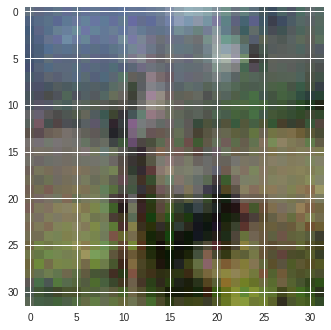

In [73]:
plt.imshow(generated_images[4011].reshape(3,32,32).transpose([1, 2, 0]))
plt.show



<function matplotlib.pyplot.show>

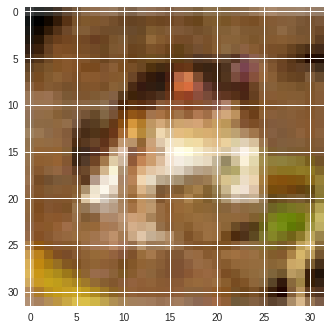

In [70]:
plt.imshow(x_train[0].reshape(3,32,32).transpose([1, 2, 0]))
plt.show

In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [101]:
model.fit(augmented, augmented_y,
         batch_size=BATCH_SIZE,
          epochs=50,
          verbose=2,
          validation_data=(x_test, y_test),
         callbacks=callbacks_list)
         

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 30s - loss: 2.8843 - acc: 0.6344 - val_loss: 1.0093 - val_acc: 0.6685
Epoch 2/50
 - 29s - loss: 2.8915 - acc: 0.6718 - val_loss: 0.7783 - val_acc: 0.7745
Epoch 3/50
 - 29s - loss: 3.1602 - acc: 0.5759 - val_loss: 0.8235 - val_acc: 0.7454
Epoch 4/50
 - 29s - loss: 2.9134 - acc: 0.6827 - val_loss: 0.7710 - val_acc: 0.7658
Epoch 5/50
 - 29s - loss: 3.1155 - acc: 0.5877 - val_loss: 0.8456 - val_acc: 0.7250
Epoch 6/50
 - 29s - loss: 3.1858 - acc: 0.5621 - val_loss: 0.8917 - val_acc: 0.7005
Epoch 7/50
 - 30s - loss: 3.0051 - acc: 0.6293 - val_loss: 0.8925 - val_acc: 0.6972
Epoch 8/50
 - 30s - loss: 3.0212 - acc: 0.6168 - val_loss: 0.9329 - val_acc: 0.7046
Epoch 9/50
 - 30s - loss: 3.0406 - acc: 0.6302 - val_loss: 0.8107 - val_acc: 0.7458
Epoch 10/50
 - 30s - loss: 2.9209 - acc: 0.6626 - val_loss: 0.8187 - val_acc: 0.7452
Epoch 11/50
 - 30s - loss: 2.9265 - acc: 0.6519 - val_loss: 0.8229 - val_acc: 0.7495
Epoch 12/50
 - 29s - los

 - 30s - loss: 0.7606 - acc: 0.7242 - val_loss: 0.8304 - val_acc: 0.7365
Epoch 35/50
 - 30s - loss: 0.7662 - acc: 0.7206 - val_loss: 0.8139 - val_acc: 0.7714
Epoch 36/50
 - 30s - loss: 0.7395 - acc: 0.7322 - val_loss: 0.8228 - val_acc: 0.7594
Epoch 37/50
 - 30s - loss: 0.7363 - acc: 0.7315 - val_loss: 0.7846 - val_acc: 0.7751
Epoch 38/50
 - 30s - loss: 0.7262 - acc: 0.7333 - val_loss: 0.7584 - val_acc: 0.7748
Epoch 39/50
 - 30s - loss: 0.7347 - acc: 0.7313 - val_loss: 0.8239 - val_acc: 0.7722
Epoch 40/50
 - 30s - loss: 0.7363 - acc: 0.7328 - val_loss: 0.7798 - val_acc: 0.7721
Epoch 41/50
 - 30s - loss: 0.7264 - acc: 0.7353 - val_loss: 0.7843 - val_acc: 0.7773
Epoch 42/50
 - 30s - loss: 0.7228 - acc: 0.7355 - val_loss: 0.7748 - val_acc: 0.7750
Epoch 43/50
 - 30s - loss: 0.7165 - acc: 0.7368 - val_loss: 0.7816 - val_acc: 0.7725
Epoch 44/50
 - 30s - loss: 0.7189 - acc: 0.7367 - val_loss: 0.7828 - val_acc: 0.7787
Epoch 45/50
 - 30s - loss: 0.7134 - acc: 0.7405 - val_loss: 0.7655 - val_acc:

In [100]:
print(type(x_train))
print(type(generated_images))
augmented = np.concatenate((x_train, generated_images))
print(augmented.shape)
augmented_y = np.concatenate((y_train, sampled_labels))
print(augmented_y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 3, 32, 32)
(60000, 10)


In [104]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7853004289865494
Test accuracy: 0.7746


In [0]:
# generate some pictures to display
noise = np.random.normal(0, 0.5, (10000, latent_size))
sampled_labels = np.array([
    [i] * 1000 for i in range(10)
])

In [0]:

sampled_labels = sampled_labels.reshape(-1, 1)
generated_images = generator.predict([noise, sampled_labels]).transpose(0, 2, 3, 1)
generated_images = np.asarray((generated_images * 127.5 + 127.5).astype(np.uint8))

In [0]:
from google.colab import files
uploaded = files.upload()

Saving caltech_dataset.pickle to caltech_dataset.pickle


In [0]:
!ls

In [0]:
with open('caltech_dataset.pickle', 'rb') as data:
    X_train, X_test, y_train, y_test = pickle.load(data)

In [0]:
x_train = X_train.astype('float32').transpose(0, 2, 3, 1)
x_test = X_test.astype('float32').transpose(0, 2, 3, 1)
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [0]:
import keras
from keras.datasets import cifar10, mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pickle

def build_model(data_augmentation, dataset):
    BATCH_SIZE = 32
    NUM_EPOCHS = 2
    NUM_CLASSES = 10
    if (dataset == 'mnist'):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
    elif (dataset == 'cifar10'):
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
    elif (dataset == 'caltech101'):
        NUM_CLASSES = 101
        with open('caltech_dataset.pickle', 'rb') as data:
            X_train, X_test, y_train, y_test = pickle.load(data)
        x_train = X_train.astype('float32')
        x_test = X_test.astype('float32')


    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     padding='same',
                     activation='relu',
                     input_shape=x_train.shape[1:]))
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3),
                     padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    model.summary()
    return model
#     model.fit(x_train, y_train,
#               batch_size=BATCH_SIZE,
#               epochs=NUM_EPOCHS,
#               verbose=2,
#               validation_data=(x_test, y_test))
#     score = model.evaluate(x_test, y_test, verbose=0)
#     print('Test loss:', score[0])
#     print('Test accuracy:', score[1])

In [0]:
try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image
from six.moves import range
import keras.backend as K
from keras.datasets import cifar10, mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.utils.generic_utils import Progbar

def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 3, 32, 32)
    cnn = Sequential()
    cnn.add(Dense(384 * 4 * 4, input_dim=latent_size, activation='relu',
                  kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(Reshape((384, 4, 4)))
    cnn.add(Conv2DTranspose(192, kernel_size=5, strides=2, padding='same', activation='relu',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2DTranspose(96, kernel_size=5, strides=2, padding='same', activation='relu',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))

    # this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size,))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    # 10 classes in CIFAR-10
    cls = Flatten()(Embedding(10, latent_size,
                              embeddings_initializer='glorot_normal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)

In [0]:
latent_size = 110
weights_path = 'params_generator_epoch_073.hdf5'
def generate_images(amount):
    generator = build_generator(latent_size)
    generator.load_weights(weights_path)
    noise = np.random.normal(0, 0.5, (amount, latent_size))
    sampled_labels = np.array([
        [i] * amount/10 for i in range(10)
    ]).reshape(-1, 1)
    generated_images = generator.predict([noise, sampled_labels]).transpose(0, 2, 3, 1)
    generated_images = np.asarray((generated_images * 127.5 + 127.5).astype(np.uint8))

    return generated_images, sampled_labels

In [21]:

from keras.datasets import cifar10, mnist
import numpy as np
#datasets = ['mnist', 'cifar10', 'caltech101']
dataset = 'cifar10'
num_images = 50000
#baseline = build_model(data_augmentation = False, dataset = dataset)
#typical_aug = build_model(data_augmentation = True, dataset = dataset)
#vae_add_near =
#vae_add_random =
#import gan_working as gan
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
scores = []
losses = []

#models_to_compare = [gan]#, vae_add_near, vae_add_random, gan]
fake_ratio = [0, 0.2, 0.4, 0.6, 0.8, 1]
#for model in models_to_compare:
for ratio in fake_ratio:
    model = build_model(data_augmentation = False, dataset = dataset)
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    x_train = x_train[:int(num_images*(1 - ratio))]
    fake, sampled_labels = generate_images(num_images*ratio)



    x_train = x_train.reshape(x_train.shape[0], 3, 32, 32)
    x_test = x_test.reshape(x_test.shape[0], 3, 32, 32)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    augmented = np.concatenate((x_train, fake))
    print(augmented.shape)
    augmented_y = np.concatenate((y_train, sampled_labels))
    print(augmented_y.shape)
    model.fit(augmented, augmented_y,
              batch_size=64,
              epochs=2,
              verbose=2,
              validation_data=(x_test, y_test),
              callbacks=callbacks_list)
    model.save_weights(
        'model-{}-fake.hdf5'.format(ratio), True)
    files.download('model-{}-fake.hdf5'.format(ratio))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    scores.append(score[0])
    print('Test accuracy:', score[1])
    losses.append(score[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 13, 13, 64)        36928     
_______

ValueError: ignored